# Logitboost Assignment
Implement Logitboost using 1D linear regressors as weak learners. At each boosting
iteration choose the weak learner that obtains the largest reduction in the loss function
on the training set $D = {(x_i, y_i), i = 1, ..., N}, \text{ with } y_i ∈ {0, 1}$:


#### Import dependencies

In [327]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

#### Data loading functions

In [328]:
def get_gisette():
    path = "data/gisette/"   
    
    train_x = np.loadtxt(path+"gisette_train.data")
    train_y = np.loadtxt(path+"gisette_train.labels")
    
    valid_x = np.loadtxt(path+"gisette_valid.data")
    valid_y = np.loadtxt(path+"gisette_valid.labels")
    
    return train_x, train_y, valid_x, valid_y



def get_dexter():
    path = "data/dexter/"

    train_x = np.loadtxt(path+"dexter_train.csv", delimiter=',')
    train_y = np.loadtxt(path+"dexter_train.labels")

    valid_x = np.loadtxt(path+"dexter_valid.csv", delimiter=',')
    valid_y = np.loadtxt(path+"dexter_valid.labels")

    return train_x, train_y, valid_x, valid_y

def get_madelon():
    path = "data/MADELON/"

    train_x = np.loadtxt(path + "madelon_train.data")
    train_y = np.loadtxt(path + "madelon_train.labels")
    test_x = np.loadtxt(path + "madelon_valid.data")
    test_y = np.loadtxt(path + "madelon_valid.labels")

    return train_x, train_y, test_x, test_y

#### Normalization function

In [329]:
def normalize(train, *args):
    mean = np.average(train, axis=0)
    standard_deviation = np.std(train, axis=0)
    columns = train, *args
    return tuple(np.divide(column-mean, standard_deviation, where=standard_deviation!=0)
                 for column in columns)


def beta_selection(x, beta0, beta1, y):
    h_xi= x * beta1 + beta0
    ytilde=2*y-1
    loss=np.sum(np.log(1+np.exp(-ytilde*h_xi.T)), axis=1)
    beta_index = np.argmin(loss)
    #print(beta_index)
    filter = np.ones_like(beta0) # array of ones of same length as beta0
    filter[beta_index] = 0 # set the spot at beta_index to 0
    beta0[filter==1] = 0 # all indices at which filter==1 are set to 0, to beta 0 has zeroes everywhere except beta_index
    beta1[filter==1] = 0
    return np.column_stack(np.dstack((beta0,beta1)))



#def h()
# I separated linear regression to its own function and transposed to vectors so they
# broadcast correctly
def linear_regressor_for_each_feature(x, y, w):
    mean_x = np.sum(x*w[np.newaxis].T, axis=0)/np.sum(w) # add an axis so we can tranpose this
    mean_y = np.sum(w*y, axis=0)/np.sum(w)
    #print("x", x.shape)
    #print("w", w.shape)
    #print("y", y.shape)
    denominators = w @ np.square(x-mean_x)
    #print("denominator", denominators.shape)
    beta_1= w*(y-mean_y)@(x-mean_x)/ denominators
    beta_0 = mean_y + beta_1 * mean_x
    beta_0 = np.ravel(beta_0) # remove extra axis
    beta_0[np.isnan(beta_0)] = 0
    beta_1[np.isnan(beta_1)] = 0
    return beta_0, beta_1


In [330]:
def train_logit(train_x, train_y, test_x, test_y, iterations):
    train_y[train_y==-1] = 0
    test_y[test_y==-1] = 0
    trainscore=[]
    testscore=[]
    h = np.zeros([train_x.shape[1],2])

    for _ in range(iterations):
        h_xi= np.sum(train_x * h[:,1] + h[:,0], axis=1)
        p=1/(1+np.exp(-h_xi))
        w_i=(p)*(1-p)
        #print("weight:", w_i.shape)
        Beta0, Beta1 = linear_regressor_for_each_feature(train_x, train_y, w_i)
        h += beta_selection(train_x, Beta0, Beta1, train_y)
        trainscore.append(1-accuracy_score(train_y, predict(train_x, h[:,1], h[:,0])))
        testscore.append(1-accuracy_score(test_y, predict(test_x, h[:,1], h[:,0])))
    #print("iteration", iterations, "num features", np.sum(np.nonzero(h[:,0])))
    #print("iteration", iterations, "h", h)
    return trainscore, testscore

In [331]:
def predict(x, b1, b0):
    prediction = np.sum(x*b1 + b0, axis=1)
    prediction[prediction >= .5] = 1
    prediction[prediction < .5] = 0
    return prediction

In [332]:
def plot(train_errors, test_errors, iteration, train_error_to_plot, test_error_to_plot):
    i = list(range(len(test_error_to_plot)))
    plt.plot(i, train_error_to_plot)
    plt.plot(i, test_error_to_plot)
    plt.legend(["Train", "Test"])
    plt.xlabel("Iterations")
    plt.ylabel("Misclassification error")
    plt.title("Error vs iterations with 100 features")

    test_errors = [f"{test_error:.3f}" for test_error in test_errors]
    train_errors = [f"{train_error:.3f}" for train_error in train_errors]
    plt.table(cellText=[*zip(iteration, train_errors, test_errors)], colLabels=['Iteration', 'Training error', 'Test error'],
              bbox=[0.0,-0.8, 1,.4], edges="closed" )
    plt.show()

def plot_logit(xtrain, ytrain, xtest, ytest):
    error_test=[]
    error_train=[]

    iterations=[10, 30, 100, 300]
    plot_train_error=[]
    plot_test_error=[]

    for x in iterations:
        trainscore, testscore = train_logit(xtrain, ytrain, xtest, ytest, x)
        error_train.append(trainscore[-1])
        error_test.append(testscore[-1])
        if x == 100:
            plot_train_error = trainscore
            plot_test_error = testscore
    plot(error_train, error_test, iterations, plot_train_error, plot_test_error)

#### Plot the error vs iteration and display final error in a table

## a) Gisette

Using the Gisette data, train a FSA classifier on the training set, starting with β(0) = 0 to select k ∈ {10, 30, 100, 300, 500} features. Plot the training loss vs iteration number for k = 30. Report in a table the misclassification errors on the training and test set for the models obtained for all these k. Plot the misclassification error on the training and test set vs k.

In [333]:
#train_x, train_y, test_x, test_y = get_gisette()

In [334]:
#plot_logit(train_x, train_y, test_x, test_y)

## b) Dexter
Repeat point a) on the dexter dataset

In [335]:
#train_x, train_y, test_x, test_y = get_dexter()

In [336]:
#plot_logit(train_x, train_y, test_x, test_y)

## c) Madelon
Repeat point a) on the madelon dataset

In [337]:
train_x, train_y, test_x, test_y = get_madelon()

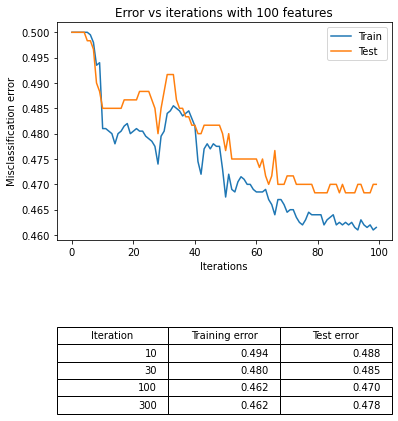

In [338]:
plot_logit(train_x, train_y, test_x, test_y)
